# Gutenberg_Project

In [20]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

import glob
import re
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import pickle

from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import datetime
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


In [19]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import Image
from keras.utils import np_utils

In [18]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Data preparation and pre-processing using Spacy and other methods (nltk)

In [ ]:
#Define a function to read the entire content of a book
def read_book(title_path): 
    #Read a book and return it as a string
    with open(title_path,"r",encoding = "utf8") as current_file:            
        text = current_file.read()
        text = text.replace("\n", " ")
        text = text.split(". ")
    return text 

In [ ]:
#Load all titles of books
book_files = glob.glob('gutenberg_project_book/*.txt')
book_files

[]

In [ ]:
#Get the corresponding author list
author_list = []
for i in range(len(book_files)):
    author_name = book_files[i].split('by_')[1].split('.txt')[0]
    author_list.append(author_name)
    
author_list

[]

In [15]:
#Create dataframe for texts of all books, authors and respective labels
from google.colab import files
uploaded = files.upload()
import io
text_df = pd.read_csv(io.BytesIO(uploaded['lemmatized_reddit_og.csv']))
text_df.info()

Saving lemmatized_reddit_og.csv to lemmatized_reddit_og.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61226 entries, 0 to 61225
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61226 non-null  int64 
 1   text        61226 non-null  object
 2   subreddit   61226 non-null  object
 3   bucket      61226 non-null  object
 4   annotator   61226 non-null  object
 5   annotation  61226 non-null  object
 6   confidence  61184 non-null  object
 7   lemmatized  61223 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.7+ MB


In [16]:
#Show the first 10 rows
text_df.head(10)

,Unnamed: 0,text,subreddit,bucket,annotator,annotation,confidence,lemmatized
0,0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident,particular debate especially funny macron expl...
1,1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident,particular debate especially funny macron expl...
2,2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident,particular debate especially funny macron expl...
3,3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident,france pretty lively lingo usually deliberatel...
4,4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident,france pretty lively lingo usually deliberatel...
5,5,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator02,Non-Moral,Confident,france pretty lively lingo usually deliberatel...
6,6,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator03,Non-Moral,Somewhat Confident,tbh marion le pen well closet fascist vs flamb...
7,7,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator00,Thin Morality,Not Confident,tbh marion le pen well closet fascist vs flamb...
8,8,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator02,Equality,Somewhat Confident,tbh marion le pen well closet fascist vs flamb...
9,9,it really is a very unusual situation isn't it...,europe,French politics,annotator03,Non-Moral,Confident,unusual situation fillon affair influence vote...


In [23]:
#Using NLTK in this project to preprocess texts instead of Spacy - download list of stop-words
import nltk
nltk.download()
stop_words=set(nltk.corpus.stopwords.words('english'))

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [24]:
#Define a function to preprocess raw texts by removing punctuations & characters, stopwords, lemmatisation
def clean_text(text, stopwords):
    le=WordNetLemmatizer()
    processed_text = re.sub(r"[^a-z ]","", text.lower())
    word_tokens=word_tokenize(processed_text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stopwords and len(w) > 2]
    # if a sentence is only one or two words long, the benefit for the training later is very small
    if len(tokens) > 2:
        cleaned_text=" ".join(tokens)
        return cleaned_text

In [25]:
#Use the above function to clean texts
text_df['clean_text'] = text_df['text'].apply(lambda x: clean_text(x, stop_words))
text_df.head(10)

,Unnamed: 0,text,subreddit,bucket,annotator,annotation,confidence,lemmatized,clean_text
0,0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident,particular debate especially funny macron expl...,particular part debate especially funny macron...
1,1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident,particular debate especially funny macron expl...,particular part debate especially funny macron...
2,2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident,particular debate especially funny macron expl...,particular part debate especially funny macron...
3,3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident,france pretty lively lingo usually deliberatel...,rfrance pretty lively lingo usually deliberate...
4,4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident,france pretty lively lingo usually deliberatel...,rfrance pretty lively lingo usually deliberate...
5,5,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator02,Non-Moral,Confident,france pretty lively lingo usually deliberatel...,rfrance pretty lively lingo usually deliberate...
6,6,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator03,Non-Moral,Somewhat Confident,tbh marion le pen well closet fascist vs flamb...,tbh marion pen would better closet fascist fla...
7,7,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator00,Thin Morality,Not Confident,tbh marion le pen well closet fascist vs flamb...,tbh marion pen would better closet fascist fla...
8,8,TBH Marion Le Pen would be better. Closet fasc...,neoliberal,French politics,annotator02,Equality,Somewhat Confident,tbh marion le pen well closet fascist vs flamb...,tbh marion pen would better closet fascist fla...
9,9,it really is a very unusual situation isn't it...,europe,French politics,annotator03,Non-Moral,Confident,unusual situation fillon affair influence vote...,really unusual situation isnt fillon affair in...


In [31]:
#Remove the original column of raw texts
processed_df = text_df[['Unnamed: 0','text','confidence']]
processed_df.head()

,Unnamed: 0,text,confidence
0,0,That particular part of the debate is especial...,Confident
1,1,That particular part of the debate is especial...,Confident
2,2,That particular part of the debate is especial...,Confident
3,3,"/r/france is pretty lively, with it's own ling...",Confident
4,4,"/r/france is pretty lively, with it's own ling...",Somewhat Confident


In [32]:
#Check null values
processed_df.isnull().sum()

Unnamed: 0     0
text           0
confidence    42
dtype: int64

In [33]:
#Remove all null values
processed_df = processed_df.dropna().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61184 entries, 0 to 61183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61184 non-null  int64 
 1   text        61184 non-null  object
 2   confidence  61184 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [34]:
#Remove duplicated rows
processed_df = processed_df.drop_duplicates().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61184 entries, 0 to 61183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61184 non-null  int64 
 1   text        61184 non-null  object
 2   confidence  61184 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [35]:
#Show the last 10 rows
processed_df.tail(10)

,Unnamed: 0,text,confidence
61174,61216,Bro I feel like there’s a different problem no...,Somewhat Confident
61175,61217,Why are you dating this guy? Dude seems like a...,Confident
61176,61218,Youre allowed to seek attention. Maybe someth...,Somewhat Confident
61177,61219,This is me. A few months ago I realised that m...,Somewhat Confident
61178,61220,"Yeeeaah, if you take him back he's still gonna...",Confident
61179,61221,Well I can discern from your vehemence toward ...,Confident
61180,61222,Kick! Punch! It's all in the mind. If you wann...,Somewhat Confident
61181,61223,Reddit can’t help you this is some seriously t...,Confident
61182,61224,Yes. Disordered eating is insidious. And Rita ...,Somewhat Confident
61183,61225,What parent would let a kid bring a Gameboy to...,Somewhat Confident


In [36]:
#Make another copy for exploratory data exploration later
clean_data = processed_df.copy(deep=True)

## 2. Perform data exploration

### * Sentence-level analysis

Max length: 1151, Min length: 33, Average Length :  199.0


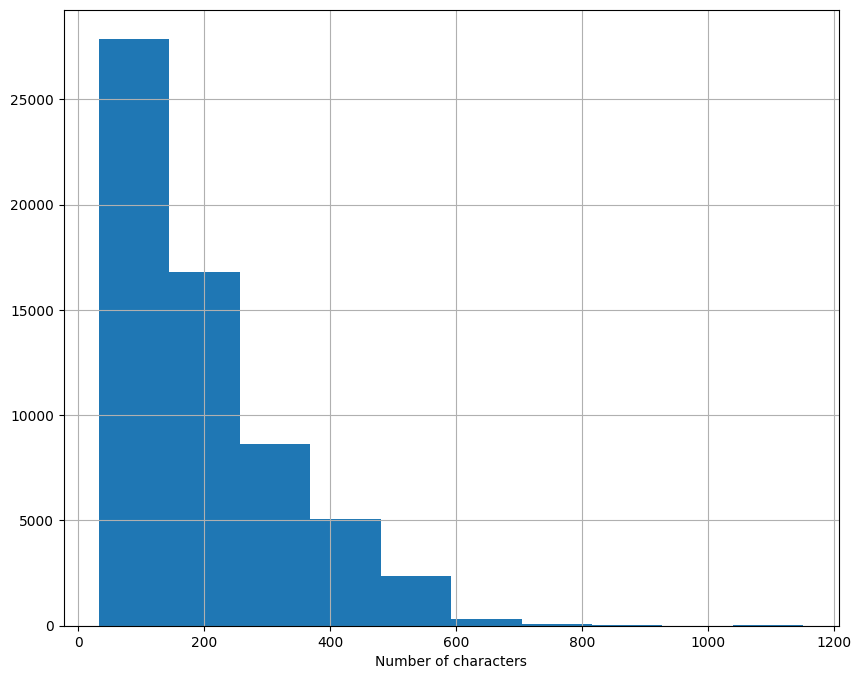

In [40]:
#Create a new column 'sentence_len'
clean_data['sentence_len'] = clean_data['text'].str.len()
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(clean_data['sentence_len']),
                                            min(clean_data['sentence_len']), round(clean_data['sentence_len'].mean(), 0)))

#Visualize number of characters in all rows (i.e. sentences)
plt.figure(figsize = (10,8))
clean_data['sentence_len'].hist()
plt.xlabel('Number of characters')
plt.show()

### Comments:
- We can see that sentences range from 12 to 1028 characters.  
- Majority of sentences are approximately between 12 and 200 characters.  

### * Word-level analysis 

Max_word_count: 100, Min_word_count: 10, Average_word_count:  34.0


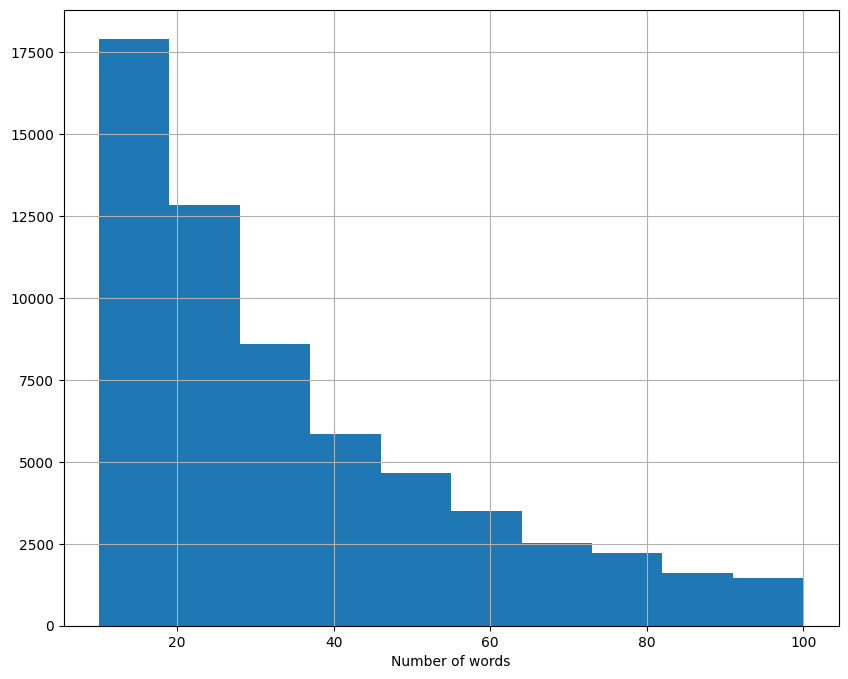

In [42]:
#Create a new column 'word_count'
clean_data['word_count'] = clean_data['text'].str.split().map(lambda x: len(x))
print('Max_word_count: {}, Min_word_count: {}, Average_word_count:  {}'.format(max(clean_data['word_count']),
                                        min(clean_data['word_count']), round(clean_data['word_count'].mean(), 0)))

#Visualize number of words in all sentences
plt.figure(figsize = (10,8))
clean_data['word_count'].hist()
plt.xlabel('Number of words')
plt.show()

### Comments:
- It is clear that number of words in each sentence range from 3 to 161.  
- Most of sentences have a total word count of 3 to 34 as shown in the above chart.  

In [44]:
#Determine the most common words (which is the highest frequencies)
#Create list of words for the entire document in the column 'text'
all_text = ' '.join(t for t in clean_data['text'])
words_list = all_text.split()

#Create a dictionary of words
word_freq = {}
for word in set(words_list):
    word_freq[word] = words_list.count(word)

#Creating dataframe of words
df_word = pd.DataFrame(word_freq.items(),columns=['word','count'])
df_word['word_len'] = df_word['word'].map(lambda x: len(x))

#Sorting values 
df_word = df_word.sort_values('count', ascending=False).reset_index(drop=True)
df_word.head(10)

,word,count,word_len
0,the,69390,3
1,to,58131,2
2,and,44684,3
3,a,42436,1
4,of,38070,2
5,is,34719,2
6,I,28501,1
7,that,26422,4
8,in,22398,2
9,you,22197,3


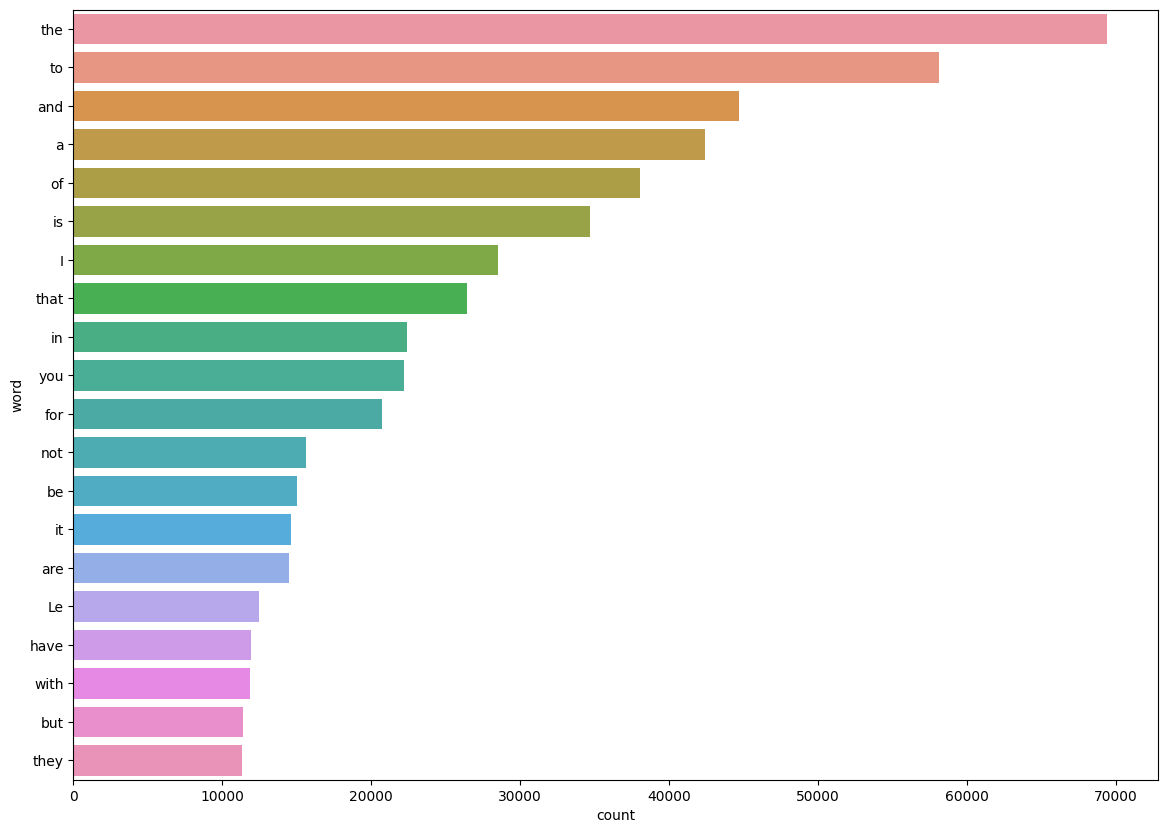

In [58]:
#Display the 20 most common words
plt.figure(figsize = (14,10))
#sb.barplot(x=df_word.values, y=df_word.index, alpha=0.8)
sb.barplot(x= df_word['count'][:20],y = df_word['word'][:20])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

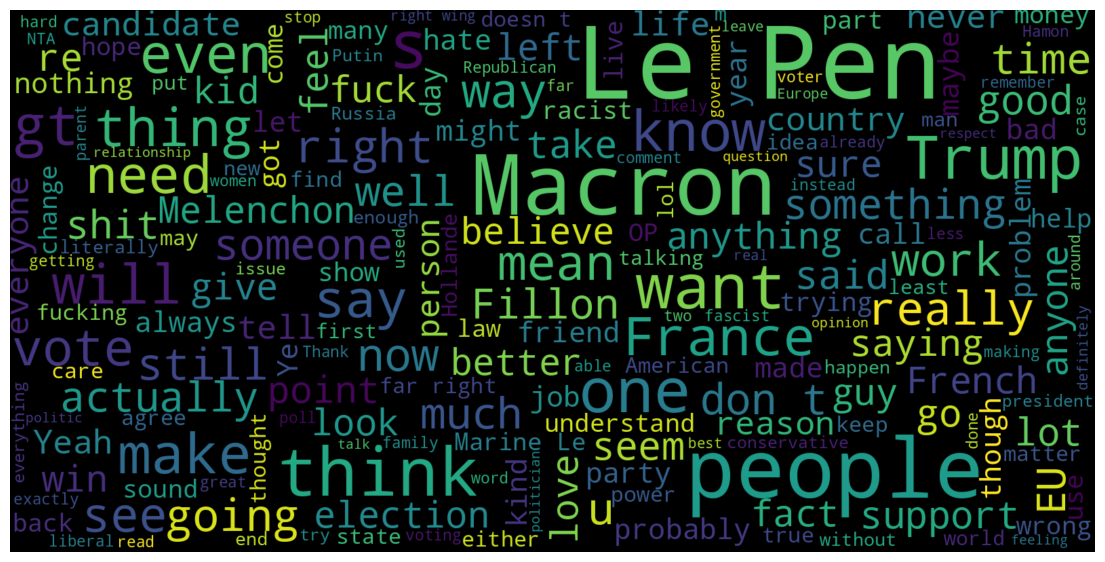

In [59]:
#WordCloud to determine which words representing the text corpus of the whole document
#Generate word cloud for all texts
import PIL
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from wordcloud import STOPWORDS, ImageColorGenerator
word_cloud = WordCloud(background_color = 'black', max_words=200, max_font_size=150,
                      width = 1600, height = 800, random_state = 42).generate(all_text)
#Show the word cloud
plt.figure(figsize=(14,16))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [60]:
import PIL

### Comments:
- We can see obviously that the most common words such as 'one','may','time','great' so on with the highest frequencies (number of counts) in the bar chart will appear in the biggest size in the word cloud.

### * Sentiment Analysis

In [61]:
#Define a function to compute 'polarity score'
def polarity_score(text):
    return TextBlob(text).sentiment.polarity

#Define a function to determine types of polarity
def sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

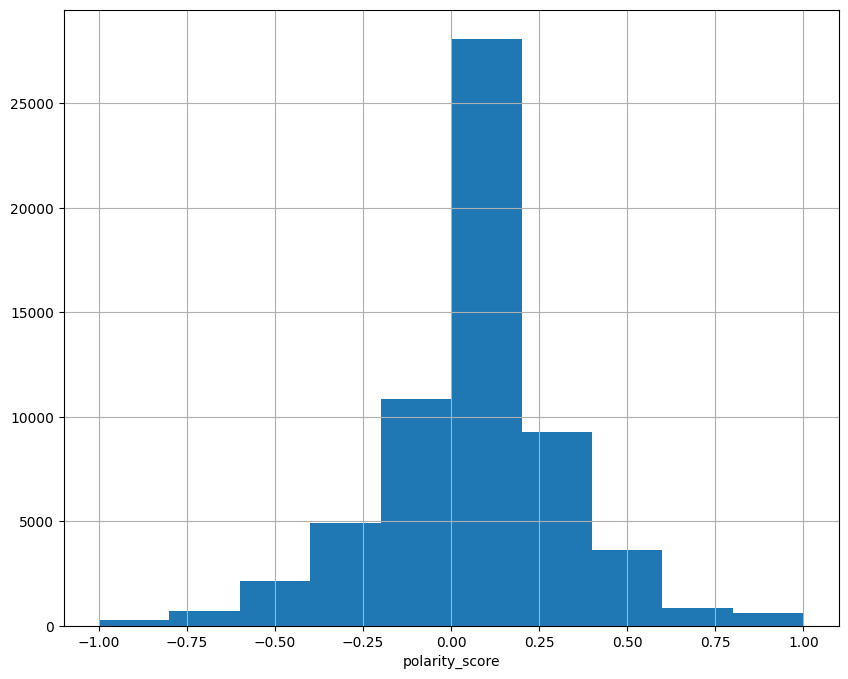

In [63]:
#Determine polarity score of the entire document
#Create a new column 'polarity score'
clean_data['polarity_score'] = clean_data['text'].apply(lambda x : polarity_score(x))

#Visualize
plt.figure(figsize = (10,8))
clean_data['polarity_score'].hist()
plt.xlabel('polarity_score')
plt.show()

### Comments:
You can see that the polarity score mainly ranges between 0.00 and 0.20. This means that the majority of texts are neutral.  

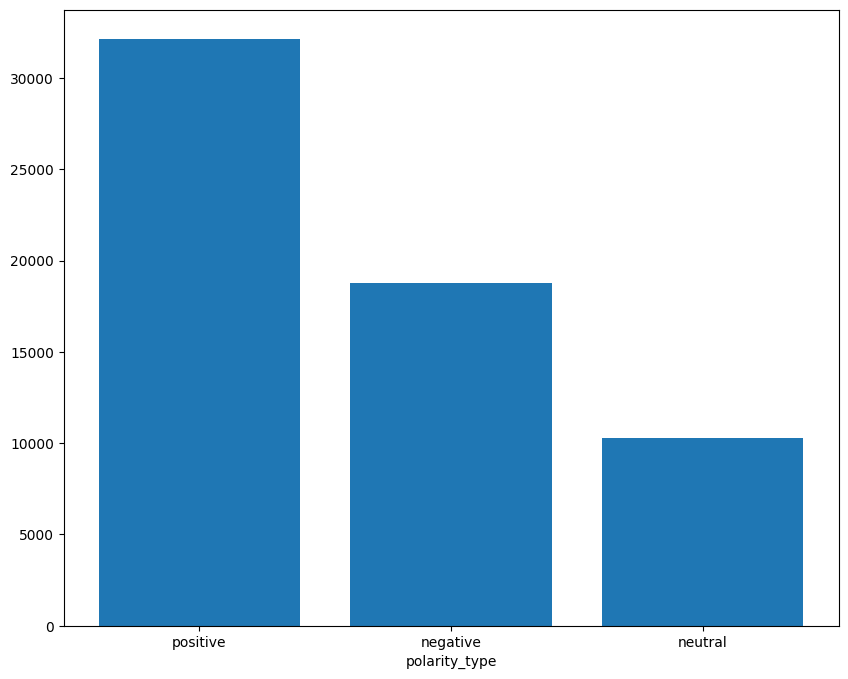

In [64]:
#Deeper classifying the texts as negative, positive and neutral based on the scores
#Create a new column 'polarity type'
clean_data['polarity_type'] = clean_data['polarity_score'].map(lambda x: sentiment(x))

#Visualize
plt.figure(figsize = (10,8))
plt.bar(clean_data.polarity_type.value_counts().index, clean_data.polarity_type.value_counts())
plt.xlabel('polarity_type')
plt.show()

### Comments:
It is clearly that majority of sentences are 'neutral' and 'positive', which is more than twice as many as 'negative'.  

In [67]:
# Logistic, Naive Bayes, RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier
def compute_models(input_source, output_target):
    
    X_train, X_test, y_train, y_test = train_test_split(input_source, output_target, test_size = 0.20, random_state = 42)
    
    models = [
            LogisticRegression(),
            DecisionTreeClassifier(),
            RandomForestClassifier(n_estimators=15), #since dataset is quite large, choose small number of trees = 15
            GradientBoostingClassifier(n_estimators=15),
            MultinomialNB()
        ]

    CV = 3
    entries =[]
    
    for model in models:
        scores_train = []
        scores_test = []
        abs_scores = []
        times = []
        gini_val = []

        for i in range(CV):
            t1 = datetime.datetime.now()
            model_name = model.__class__.__name__
            model.fit(X_train,y_train)
            t2 = datetime.datetime.now()
            d = round((t2-t1).microseconds/1000,1)
            score_train = model.score(X_train,y_train)
            score_test = model.score(X_test,y_test)
            abs_score = abs(score_train - score_test)
            y_prob = model.predict_proba(X_test)
            auc_val = roc_auc_score(y_test, y_prob, multi_class='ovr')
            gini = 2 * auc_val - 1

            scores_train.append(score_train)
            scores_test.append(score_test)
            abs_scores.append(abs_score)
            gini_val.append(gini)
            times.append(d)

        print('Scores of test dataset:')
        print(model.__class__.__name__, scores_test)
        entries.append([model_name,np.array(scores_train).mean(),
                                np.array(scores_test).mean(), np.array(abs_scores).mean(),
                                np.array(gini_val).mean(), np.array(times).mean()])

      
    cv_df = pd.DataFrame(entries, columns=['model_name','score_train_mean',
                                   'score_test_mean','abs|score|','gini_mean','time_mean'])
    return cv_df

In [70]:
#Create a CountVectorizer instance
count_vec = CountVectorizer(stop_words = 'english', max_features=2000)

In [76]:
#Separate 'source' and 'target'
source = clean_data['text']
target = clean_data['confidence']

In [78]:
#Create array for source data
source_text = np.array(source)
source_text[:10]

array(['That particular part of the debate is especially funny. Macron was explaining he did not think FN voters were evil and that from where he comes from he knew many, and she was like "ooooh the evil FN invaders they\'re everywhere...!" Self-awareness: zero.',
       'That particular part of the debate is especially funny. Macron was explaining he did not think FN voters were evil and that from where he comes from he knew many, and she was like "ooooh the evil FN invaders they\'re everywhere...!" Self-awareness: zero.',
       'That particular part of the debate is especially funny. Macron was explaining he did not think FN voters were evil and that from where he comes from he knew many, and she was like "ooooh the evil FN invaders they\'re everywhere...!" Self-awareness: zero.',
       '/r/france is pretty lively, with it\'s own lingo that is usually deliberately bad translations - shitpost is "cacapoteau" or "compost", crosspost is "croixpoteau", etc. There\'s a mix of memes, pol

### Comments:
We can see that model 'MultinomialNB' has the highest Gini value (0.96) with the shortest time compared to the other models. Therefore, we will choose this model to compute later.

In [82]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.20, random_state = 42)

NameError: ignored

In [ ]:
#We use the algorithm Multinomial Naive Bayes to build model
multi_nb_instance = MultinomialNB()

In [ ]:
#Fit the model with train dataset
multi_nb_model = multi_nb_instance.fit(X_train_c, y_train_c)

In [ ]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', multi_nb_model.score(X_train_c, y_train_c))
print('R2 score of test dataset: ', multi_nb_model.score(X_test_c, y_test_c))

In [ ]:
#Compute the prediction based on 'X_test'
y_pred_c = multi_nb_model.predict(X_test_c)

In [ ]:
#Compute accuracy and AUC of the model
accuracy_c = accuracy_score(y_test_c, y_pred_c)
y_prob_c = multi_nb_model.predict_proba(X_test_c)
auc_c = roc_auc_score(y_test_c, y_prob_c, multi_class = 'ovr')
print('Accuracy of the model is:', round(accuracy_c,2))
print("Auc of the model is:", round(auc_c,2))

In [ ]:
# Plot ROC
fig, ax = plt.subplots(figsize=(10,8))
classes = np.unique(y_test_c)  #or can use y_train_c
y_test_c_array = pd.get_dummies(y_test_c, drop_first = False).values
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_c_array[:,i], y_prob_c[:,i])
    ax.plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
    
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate',
                                    ylabel="True Positive Rate", title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

In [ ]:
#Print confusion matrix
confusion_matrix(y_test_c, y_pred_c)

In [ ]:
#Print classification report
print(classification_report(y_test_c, y_pred_c, target_names = author_list))

In [ ]:
#Save the model with tfidf technique
pickle.dump(multi_nb_model, open("NLP_model/bow_multinb_model.pickle","wb"))

### Comments:
- With the Bags-of-Words technique, the model MultinomialNB obtains good performance. The model is neither overfitting nor underfitting.  
- The model achieves good results, which has accuracy of 0.82 and AUC value of 0.98.

## 4. Similar to 3., but using TF-IDF

In [ ]:
#Create a Tf-idf Vectorizer instance
tfidf_vec = TfidfVectorizer(stop_words = 'english', max_features=2000)

In [ ]:
#Fit the full data
tfidf_vec.fit(source_text)

In [ ]:
#Transform source text array into a sparse numeric matrix
tfidf_matrix = tfidf_vec.transform(source_text)
tfidf_matrix

In [ ]:
#Then convert it into a numeric array X
X = tfidf_matrix.toarray()
X

In [ ]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
#We use the algorithm Multinomial Naive Bayes to build model
tfidf_multi_nb = MultinomialNB()

In [ ]:
#Fit the model with train dataset
tfidf_multinb_model = tfidf_multi_nb.fit(X_train_t, y_train_t)

In [ ]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', tfidf_multinb_model.score(X_train_t, y_train_t))
print('R2 score of test dataset: ', tfidf_multinb_model.score(X_test_t, y_test_t))

In [ ]:
#Compute the prediction
y_pred_t = tfidf_multinb_model.predict(X_test_t)

In [ ]:
#Compute accuracy and AUC of the model
accuracy_t = accuracy_score(y_test_t, y_pred_t)
y_prob_t = tfidf_multinb_model.predict_proba(X_test_t)
auc_t = roc_auc_score(y_test_t, y_prob_t, multi_class = 'ovr')
gini_t = 2 * auc_t - 1
print('Accuracy of the model after using TF-IDF is:', round(accuracy_t,2))
print("Auc of the model after using TF-IDF is:", round(auc_t,2))
print("Gini of the model after using TF-IDF is:", round(gini_t,2))

In [ ]:
#Print confusion matrix
confusion_matrix(y_test_t, y_pred_t)

In [ ]:
#Print classification report
print(classification_report(y_test_t, y_pred_t, target_names = author_list))

In [ ]:
#Save the model with tfidf technique
pickle.dump(tfidf_multinb_model, open("NLP_model/tfidf_multinb_model.pickle","wb"))

### Comments:
- Compared to Bags of Words, the TF-IDF technique achieves the same AUC value (0.98), which means the same Gini value (0.96). 

## 5. Similar to 3., but using word2vec

In [ ]:
#Generate a new column 'word_clean_text'
clean_data['word_clean_text'] = clean_data['clean_text'].str.split()
clean_data.head()

In [ ]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(clean_data['word_clean_text'], clean_data['author_class'], 
                                                                            test_size = 0.20, random_state = 42)

In [ ]:
#Create the word2vec model
w2v_model = gensim.models.Word2Vec(X_train_w2v, vector_size=100, window=5, min_count=1, max_vocab_size=3000)

In [ ]:
#Generate aggregated sentence vectors based on the word vectors for each word in the sentence
words_dict = set(w2v_model.wv.index_to_key)
X_train_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_train_w2v])
X_test_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_test_w2v])

In [ ]:
# Compute average sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_sent_avg = []
for v in X_train_sent:
    if v.size:
        X_train_sent_avg.append(v.mean(axis=0))
    else:
        X_train_sent_avg.append(np.zeros(100, dtype=float))
        
X_test_sent_avg = []
for v in X_test_sent:
    if v.size:
        X_test_sent_avg.append(v.mean(axis=0))
    else:
        X_test_sent_avg.append(np.zeros(100, dtype=float))

In [ ]:
#In this case, we use Random Forest instead of Multinomial Naive Bayes to build model
#because MultinomialNB does not support with negative values
w2v_rfc = RandomForestClassifier(n_estimators=100)

In [ ]:
#Fit the model with train dataset
w2v_rfc_model = w2v_rfc.fit(X_train_sent_avg, y_train_w2v)

In [ ]:
# Use the trained model to make predictions on the test data
y_pred_w2v = w2v_rfc_model.predict(X_test_sent_avg)

In [ ]:
#Compute accuracy and AUC and Gini of the model
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
y_prob_w2v = w2v_rfc_model.predict_proba(X_test_sent_avg)
auc_w2v = roc_auc_score(y_test_w2v, y_prob_w2v, multi_class = 'ovr')
gini_w2v = 2 * auc_w2v - 1
print('Accuracy of the model after using word2vec is:', round(accuracy_w2v,2))
print("Auc of the model after using word2vec is:", round(auc_w2v,2))
print("Gini of the model after using word2vec is:", round(gini_w2v,2))

In [ ]:
#Print confusion matrix
confusion_matrix(y_test_w2v, y_pred_w2v)

In [ ]:
#Print classification report
print(classification_report(y_test_w2v, y_pred_w2v, target_names = author_list))

In [ ]:
#Save the model with word2vec technique
pickle.dump(w2v_rfc_model, open("NLP_model/w2v_rfc_model.pickle","wb"))

### Comments:
- This Word2Vec technique obtains lower AUC value (0.91) than that of Bags of Words and TF-IDF techniques (which have AUC value of 0.98).

## 6. Appy RNN to do classification

In [ ]:
#Show the clean data for quick reference
clean_data.head()

In [ ]:
#Create the input and output datasets
X_rnn = clean_data['clean_text']
y_rnn = clean_data['author_class']    
y_rnn = np_utils.to_categorical(y_rnn) 

In [ ]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rnn, y_rnn, test_size = 0.20, random_state = 42)

In [ ]:
#Normalizing texts of the whole document
max_words = 1000 
max_len = 100 

tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train_r)

sequences = tok.texts_to_sequences(X_train_r)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
print(sequences[:2])

In [ ]:
#Create a deep learning network - RNN
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, 800))
rnn_model.add(Dropout(0.7))
rnn_model.add(LSTM(64))
rnn_model.add(Dropout(0.7))
rnn_model.add(Dense(256, activation='relu')) 
rnn_model.add(Dropout(0.7))
rnn_model.add(Dense(10, activation='softmax'))

In [ ]:
#Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Summary of the model
rnn_model.summary()

In [ ]:
#Model diagram for reference
plot_model(rnn_model, to_file='RNN_model/Gutenberg_RNN_NLP_model_29052022.png', show_shapes=True)
Image(filename='RNN_model/Gutenberg_RNN_NLP_model_29052022.png')

In [ ]:
# Create callback to make early stopping
callbacks = [EarlyStopping(monitor='val_loss', 
                      patience=5, 
                      mode='auto')
]

In [ ]:
#Fit the model
history = rnn_model.fit(sequences_matrix, y_train_r,
                    batch_size=32,             
                    epochs=1,
                    validation_split=0.2,
                    verbose = 0,
                    callbacks=callbacks,
                   )

In [ ]:
#Visualize 
history_df = pd.DataFrame(history.history)
print(history_df.tail())
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

### Comments:
- After the training stage, we can see that the val loss of validation dataset and loss of train dataset are small and close together meanwhile accuracies of validation and train dataset increase and remain stable at high value.  
- We use Early Stopping to prevent the model from increasing val_loss and loss again.

In [ ]:
#Evaluate the model based on test dataset
test_sequences = tok.texts_to_sequences(X_test_r)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
#Tính accuracy của model
acc_rnn = rnn_model.evaluate(test_sequences_matrix, y_test_r)

In [ ]:
#Save the model
rnn_model.save('RNN_model/Gutenberg_RNN_NLP_29052022.h5')
print('save!!!')

In [ ]:
#Compute the prediction values
y_pred_r = rnn_model.predict(test_sequences_matrix)
#Get max value for each class
y_pred_r = np.argmax(y_pred_r, axis=-1)
y_test_rnn = np.argmax(y_test_r, axis=-1)

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_rnn, y_pred_r)
cm

In [ ]:
#Print Classification Report
print(classification_report(y_test_rnn, y_pred_r, target_names=author_list))

## 7. Using unsupervised technique, visualize bar graphs for clusters containing 10 author documents. Adjust by silhouette scores.  
- For clustering, we will use the text dataset after being processed by TF-IDF with max_features = 2000.  
- Use algorithms like KMeans, GMM to find optimal number of clusters via silhouette scores or elbow method.  

In [83]:
#Input dataset after being processed by TF-IDF
input_dataset = tfidf_matrix.toarray()

NameError: ignored

In [ ]:
#Find the optimal number of clusters using silhouette score with GMM
k_range = np.arange(2,15)
sil_score = []
for k in k_range:
    cluster = GaussianMixture(n_components=k, random_state=42)
    y_pred = cluster.fit_predict(input_dataset)
    score = silhouette_score(input_dataset, y_pred)
    sil_score.append(score)

plt.plot(k_range, sil_score, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette score with k cluster')
plt.show()

In [ ]:
#Find the optimal number of clusters using Elbow Method with KMeans
sse = {}
k_range = np.arange(2,15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(input_dataset)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
    
#Visualize to choose k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sb.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Comments:
- After using KMeans with Elbow Method or GMM algorithms with Silhouette Score, I still cannot obtain the optimal k, which is the number of clusters in this case.
- Currently, I have not found any feasible solution to solve this issue.  

## 8. Using LSA, LDA and NNMF, print out top ten words (with their highest loading) for each topic modeling. Analyze and compare among three methods.

### 8.1 LSA - Latent Semantic Analysis
- Is a popular dimensionality-reduction technique which is the same method as Singular Value Decomposition. In other words, we can address this technique as LSA or SVD.  
- It is generally implemented with Tfidf values and not with the Bags-of-Words.

In [ ]:
#Create LSA model with 10 components (i.e representing 10 authors)
lsa_instance = TruncatedSVD(n_components=10, random_state=42)

In [ ]:
#Transform the data after using tfidf technique
lsa_data = lsa_instance.fit_transform(tfidf_matrix)

In [ ]:
#Get the 10 most important words for each latent component (indirectly representing for each author)
lsa_vocab = tfidf_vec.get_feature_names()

for i, comp in enumerate(lsa_instance.components_):
    vocab_comp = zip(lsa_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

In [ ]:
#To better visualize words in a topic, we can utilize the wordcloud and choose top 50 words for each topic
def draw_word_cloud(index, model_type):
    imp_words_topic = ""
    comp = model_type.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic + " " + word[0]

    wc = WordCloud(width=600, height=400, random_state=42).generate(imp_words_topic)
    plt.figure( figsize=(8,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
#Draw wordcloud of topic 0 with LSA technique
draw_word_cloud(0, lsa_instance)

### 8.2 LDA - Latent Dirichlet Allocation 

In [102]:
#Create LDA model with 10 components (i.e representing 10 authors)
lda_instance = LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=5)

In [105]:
#Create a Tf-idf Vectorizer instance
tfidf_vec = TfidfVectorizer(stop_words = 'english', max_features=2000)

In [106]:
#Fit the full data
tfidf_vec.fit(source_text)

TfidfVectorizer(max_features=2000, stop_words='english')

In [107]:
#Transform source text array into a sparse numeric matrix
tfidf_matrix = tfidf_vec.transform(source_text)
tfidf_matrix

<61184x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 690239 stored elements in Compressed Sparse Row format>

In [89]:
X = tfidf_matrix.toarray()
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26058811],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26058811],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26058811],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [90]:
#Transform the data after using tfidf technique
lda_data = lda_instance.fit_transform(tfidf_matrix)

In [96]:
lsa_instance = TruncatedSVD(n_components=10, random_state=42)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [109]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
lda_vocab = tfidf_vec.get_feature_names()
for i, comp in enumerate(lda_instance.components_):
    vocab_comp = zip(lda_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

NameError: name 'tfidf_vec' is not defined

In [114]:
def draw_word_cloud(index, model_type):
    imp_words_topic = ""
    comp = model_type.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic + " " + word[0]

    wc = WordCloud(width=600, height=400, random_state=42).generate(imp_words_topic)
    plt.figure( figsize=(8,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [115]:
#Draw wordcloud of topic 0 with LDA technique
draw_word_cloud(0, lda_instance)

AttributeError: ignored

### 8.3 NNMF - Non Negative Matrix Factorization

In [ ]:
#Create NMF model with 10 components (i.e representing 10 authors)
nmf_instance = NMF(n_components=10, solver="mu")

In [ ]:
#Transform the data after using tfidf technique
nmf_data = nmf_instance.fit_transform(tfidf_matrix)

In [ ]:
#Get the 10 most important words for each latent component (indirectly representing for each author)
nmf_vocab = tfidf_vec.get_feature_names()

for i, comp in enumerate(nmf_instance.components_):
    vocab_comp = zip(nmf_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

In [ ]:
#Draw wordcloud of topic 0 with NMF technique
draw_word_cloud(0, nmf_instance)

### Comments:
- These 3 algorithms (LSA, LDA, NNMF) are usually used with TF-IDF technique.  
- LDA and NNMF algorithms are more popular than LSA.  
- NNMF provides more coherent topics and less time execution than LDA.